2024-05-15 23:17:40.577303: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-05-15 23:17:40.577333: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-15 23:17:40.577341: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-15 23:17:40.577382: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-15 23:17:40.577400: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2024-05-15 23:17:41.434622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


562/562 [==============================] - ETA: 0s - loss: 0.6735 - accuracy: 0.5697

2024-05-15 23:18:01.910291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


562/562 [==============================] - 24s 38ms/step - loss: 0.6735 - accuracy: 0.5697 - val_loss: 0.6467 - val_accuracy: 0.6150
Epoch 2/10
562/562 [==============================] - 20s 35ms/step - loss: 0.6481 - accuracy: 0.6187 - val_loss: 0.6337 - val_accuracy: 0.6300
Epoch 3/10
562/562 [==============================] - 20s 35ms/step - loss: 0.6439 - accuracy: 0.6201 - val_loss: 0.6475 - val_accuracy: 0.6309
Epoch 4/10
562/562 [==============================] - 20s 35ms/step - loss: 0.6435 - accuracy: 0.6220 - val_loss: 0.6342 - val_accuracy: 0.6261
Epoch 5/10
562/562 [==============================] - 20s 35ms/step - loss: 0.6427 - accuracy: 0.6277 - val_loss: 0.6319 - val_accuracy: 0.6374
Epoch 6/10
562/562 [==============================] - 20s 35ms/step - loss: 0.6382 - accuracy: 0.6328 - val_loss: 0.6285 - val_accuracy: 0.6391
Epoch 7/10
562/562 [==============================] - 20s 35ms/step - loss: 0.6340 - accuracy: 0.6381 - val_loss: 0.6271 - val_accuracy: 0.6477
Epo

2024-05-15 23:21:02.186632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1016/1016 [==============================] - 13s 12ms/step


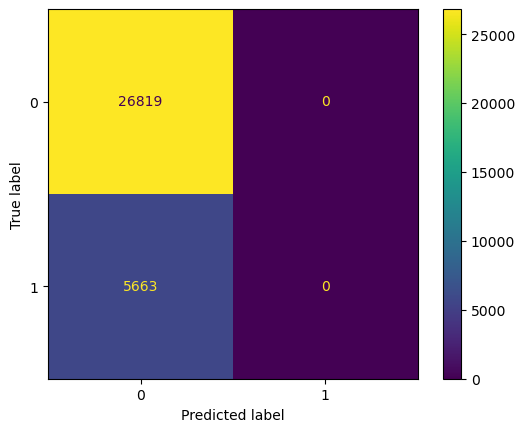

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LayerNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import MultiHeadAttention, Input, Add
import matplotlib.pyplot as plt

# Load manually selected training and testing CSV files
train_files = ['Data/29_tracks_labeled.csv', 'Data/27_tracks_labeled.csv', 'Data/25_tracks_labeled.csv', 'Data/22_tracks_labeled.csv', 'Data/20_tracks_labeled.csv']  # Add your training files here
test_files = ['Data/28_tracks_labeled.csv', 'Data/26_tracks_labeled.csv', 'Data/21_tracks_labeled.csv']  # Add your testing files here

# Load and concatenate training data
train_data = pd.concat([pd.read_csv(file) for file in train_files], ignore_index=True)

# Load and concatenate testing data
test_data = pd.concat([pd.read_csv(file) for file in test_files], ignore_index=True)

# Assuming the datasets have been properly labeled and contain the 'stopped_before_pedestrian' column
features_cols = [
    'xCenter', 'yCenter', 'xVelocity', 'yVelocity'
]

# Group data by 'frame' to consider all participants in a frame
def create_frame_sequences(data, features, label_col):
    sequences = []
    labels = []
    grouped = data.groupby('frame')
    for frame, group in grouped:
        seq = group[features].values
        lbl = group[label_col].max()  # Use max as a label for the frame; change as needed
        sequences.append(seq)
        labels.append(lbl)
    return sequences, labels

X_train_seq, y_train_seq = create_frame_sequences(train_data, features_cols, 'stopped_before_pedestrian')
X_test_seq, y_test_seq = create_frame_sequences(test_data, features_cols, 'stopped_before_pedestrian')

# Pad sequences to the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_seq_len = max(max(len(seq) for seq in X_train_seq), max(len(seq) for seq in X_test_seq))
X_train_seq = pad_sequences(X_train_seq, maxlen=max_seq_len, dtype='float32', padding='post', truncating='post')
X_test_seq = pad_sequences(X_test_seq, maxlen=max_seq_len, dtype='float32', padding='post', truncating='post')

# Normalize features
scaler = StandardScaler()
X_train_seq = scaler.fit_transform(X_train_seq.reshape(-1, X_train_seq.shape[-1])).reshape(X_train_seq.shape)
X_test_seq = scaler.transform(X_test_seq.reshape(-1, X_test_seq.shape[-1])).reshape(X_test_seq.shape)

# Apply SMOTE to balance the training data
X_train_flat = X_train_seq.reshape((X_train_seq.shape[0], -1))
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train_seq)
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], max_seq_len, X_train_seq.shape[-1]))

# Compute class weights for resampled data
class_weights_resampled = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weight_dict_resampled = dict(enumerate(class_weights_resampled))

# Create validation split manually
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)

# Convert labels to numpy arrays
y_train_final = np.array(y_train_final)
y_val = np.array(y_val)

# Transformer model
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Model architecture
embed_dim = X_train_final.shape[-1]  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(max_seq_len, X_train_final.shape[-1]))
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(inputs)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
x = Dropout(0.1)(x)
outputs = Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
model.fit(X_train_final, y_train_final, epochs=10, batch_size=64, validation_data=(X_val, y_val), class_weight=class_weight_dict_resampled, callbacks=[early_stopping])

# Predictions
y_pred = model.predict(X_test_seq)
y_pred = (y_pred > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test_seq, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
